In [1]:
"""
Defines one instance of a genome, which is a collection of genes and a fitness score.
 - Genes are a list of weights that are applied to each indicator to dictate whether to buy or sell.
 - Fitness is a score that is calculated by the fitness function, which is the total profit of the genome on BTC.
"""
from ta.volatility import BollingerBands
from ta.trend import ADXIndicator
from ta.momentum import RSIIndicator
import numpy as np
import pandas as pd
import random

class Genome():
	def __init__(self, fitness, buy_genes, sell_genes):
		self.fitness = fitness
		self.buy_genes = buy_genes
		self.sell_genes = sell_genes

	def __str__(self):
		return "Genome: fitness = {}, buy_genes = {}, sell_genes = {}".format(self.fitness, self.buy_genes, self.sell_genes)

	def __repr__(self):
		return self.__str__()

class Dataset():
	def __init__(self, data):
		self.data = data
		self.bollinger()
		self.bollingerlong()
		self.adx()
		self.save()
	
	def bollingerlong(self):
	
		short_window = 20 ### optimization target
		medium_window = 100 ### optimization target

		indicator_bb = BollingerBands(close=self.data["close"], window=short_window, window_dev=2)
		indicator_bb_m = BollingerBands(close=self.data["close"], window=medium_window, window_dev=2)
		df_temp = pd.DataFrame()

		# Add Bollinger Bands features
		df_temp['mavg_s'] = indicator_bb.bollinger_mavg()
		df_temp['mavg_m'] = indicator_bb_m.bollinger_mavg()

		self.data["bollingerlong_buy"] = np.where(df_temp['mavg_m'] > df_temp['mavg_s'], 1,-1)
		self.data["bollingerlong_sell"] = np.where(df_temp['mavg_m'] < df_temp['mavg_s'], 1,-1)
	
	def bollinger(self):
	
		short_window = 10 ### optimization target
		medium_window = 50 ### optimization target

		indicator_bb = BollingerBands(close=self.data["close"], window=short_window, window_dev=2)
		indicator_bb_m = BollingerBands(close=self.data["close"], window=medium_window, window_dev=2)
		df_temp = pd.DataFrame()

		# Add Bollinger Bands features
		df_temp['mavg_s'] = indicator_bb.bollinger_mavg()
		df_temp['mavg_m'] = indicator_bb_m.bollinger_mavg()

		self.data["bollinger_buy"] = np.where(df_temp['mavg_m'] > df_temp['mavg_s'], 1,-1)
		self.data["bollinger_sell"] = np.where(df_temp['mavg_m'] < df_temp['mavg_s'], 1,-1)

	def adx(self):
		#copied https://medium.com/codex/algorithmic-trading-with-average-directional-index-in-python-2b5a20ecf06a
		short_window = 10 ### optimization target
		adx_indcator = ADXIndicator(high=self.data["high"],low=self.data["low"],close=self.data["close"], window=short_window)
		temp_df = pd.DataFrame(data=[adx_indcator.adx(),adx_indcator.adx_pos(),adx_indcator.adx_neg()]).transpose()
		
		temp_df["adx_buy"] = -1
		temp_df["adx_sell"] = -1
		for i in range(len(self.data)):
			if(temp_df["adx"].iloc[i-1]<25 and temp_df["adx"].iloc[i]> 25 and temp_df["adx_pos"].iloc[i] > temp_df["adx_neg"].iloc[i]):
				temp_df["adx_buy"].iloc[i] = 1

			if(temp_df["adx"].iloc[i-1]<25 and temp_df["adx"].iloc[i]> 25 and temp_df["adx_pos"].iloc[i] < temp_df["adx_neg"].iloc[i]):
				temp_df["adx_sell"].iloc[i] = 1

		self.data["adx_buy"] = temp_df["adx_buy"]
		self.data["adx_sell"] = temp_df["adx_sell"]

	def save(self):
		self.data.to_csv("processed_data.csv")
	
	def __str__(self):
		return "Dataset: size = {}".format(len(self.data))

	def __repr__(self):
		return self.__str__()

class BuyIndicators():
	def __init__(self):
		self.indicators = ["bollinger_buy","adx_buy","bollingerlong_buy"]
		self.size = len(self.indicators)

	def __str__(self):
		return "BuyIndicators: size = {}, indicators = {}".format(self.size, self.indicators)

	def __repr__(self):
		return self.__str__()

class SellIndicators():
	def __init__(self):
		self.indicators = ["bollinger_sell","adx_sell","bollingerlong_sell"]
		self.size = len(self.indicators)

	def __str__(self):
		return "SellIndicators: size = {}, indicators = {}".format(self.size, self.indicators)

	def __repr__(self):
		return self.__str__()


Dataset(pd.read_csv("raw_data.csv"))

c:\Users\kaneb.DESKTOP-A94UFDN\AppData\Local\Programs\Python\Python39\lib\site-packages\ta\trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
c:\Users\kaneb.DESKTOP-A94UFDN\AppData\Local\Programs\Python\Python39\lib\site-packages\ta\trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
c:\Users\kaneb.DESKTOP-A94UFDN\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Dataset: size = 719

In [22]:
class TrainGenomes():
	def __init__(self, population_size, data):
		self.population_size = population_size
		self.data = data
		self.buy_genes = BuyIndicators()
		self.sell_genes = SellIndicators()

	def train(self):
		# Initialize the population
		population = self.initialize_population(self.population_size, self.buy_genes, self.sell_genes)
		# Evaluate the population
		population = self.evaluate_population(population)
		# Sort the population by fitness
		population.sort(key=lambda x: x.fitness, reverse=True)
		# # Keep track of the best genome
		self.save_population(population)
		best_genome = population[0]
		print(best_genome)
		# # Keep track of the number of generations with no improvement
		# no_improvement = 0
		# # Keep track of the number of generations
		# generations = 0
		# # Keep track of the time
		# start_time = time.time()
		# Keep track of the best fitness
	def save_population(self,population):
		#save list of population classes as csv
		lst = [x.__dict__ for x in population]
		pd.DataFrame(lst).to_csv("population.csv")


	def initialize_population(self, population_size, buy_genes, sell_genes):
		population = []
		for i in range(population_size):
			buy_genes = np.random.uniform(-1,1,buy_genes.size)
			sell_genes = np.random.uniform(-1,1,sell_genes.size)
			population.append(Genome(0, buy_genes, sell_genes))

		return population
	
	def evaluate_population(self, population):
		for genome in population:
			genome.fitness = self.fitness(genome)
		return population
	
	def fitness(self, genome):
		buying = True
		fiat_money = 100
		btc_money = 0
		fee = 0.02 # Each buy or sell event costs 2% of current holdings.
		
		#Create a buy and sell dataframe using the genomes weights and the indicators status
		temp_df = pd.DataFrame()
		for i,indicator in enumerate(self.buy_genes.indicators):
			try:
				temp_df["buy"] += self.data[indicator] * genome.buy_genes[i]
			except KeyError:
				temp_df["buy"] = self.data[indicator] * genome.buy_genes[i]

		for i,indicator in enumerate(self.sell_genes.indicators):
			try:
				temp_df["sell"] += self.data[indicator] * genome.sell_genes[i]
			except KeyError:
				temp_df["sell"] = self.data[indicator] * genome.sell_genes[i]
		
		for index, row in self.data.iterrows():
			if buying:
				if temp_df.iloc[index]["buy"] > 0:
					btc_money = ( fiat_money / row['close'] ) * (1 - fee)
					fiat_money = 0
					buying = False

			elif temp_df.iloc[index]["sell"] > 0:
					fiat_money = (btc_money * row['close'] ) * (1 - fee)
					btc_money = 0
					buying = True
		
		return fiat_money + (btc_money * self.data.iloc[-1]['close'])


	# def select_parents(self, population):
	# 	# Select the parents using tournament selection
	# 	parent1 = self.tournament_selection(population)
	# 	parent2 = self.tournament_selection(population)
	# 	return parent1, parent2
	
	# def tournament_selection(self, population):
	# 	# Select two random genomes
	# 	genome1 = population[np.random.randint(len(population))]
	# 	genome2 = population[np.random.randint(len(population))]
	# 	# Return the fitter genome
	# 	return genome1 if genome1.fitness > genome2.fitness else genome2
	
	# def crossover(self, parent1, parent2):
	# 	# Select a crossover point
	# 	crossover_point = np.random.randint(1, parent1.size)
	# 	# Create the offspring
	# 	offspring1 = Genome(parent1.size, 0, np.concatenate((parent1.genes[:crossover_point], parent2.genes[crossover_point:])))
	# 	offspring2 = Genome(parent1.size, 0, np.concatenate((parent2.genes[:crossover_point], parent1.genes[crossover_point:])))
	# 	return offspring1, offspring2

	# def mutate(self, genome):
	# 	# Select a mutation point
	# 	mutation_point = np.random.randint(genome.size)
	# 	# Mutate the genome
	# 	genome.genes[mutation_point] = 1 if genome.genes[mutation_point] == 0 else 0
	# 	return genome



TrainGenomes(1000, pd.read_csv("processed_data.csv")).train()



Genome: fitness = 139.0620407538835, buy_genes = [ 0.84952027  0.35364097 -0.69188859], sell_genes = [-0.19166047  0.914638    0.69647552]


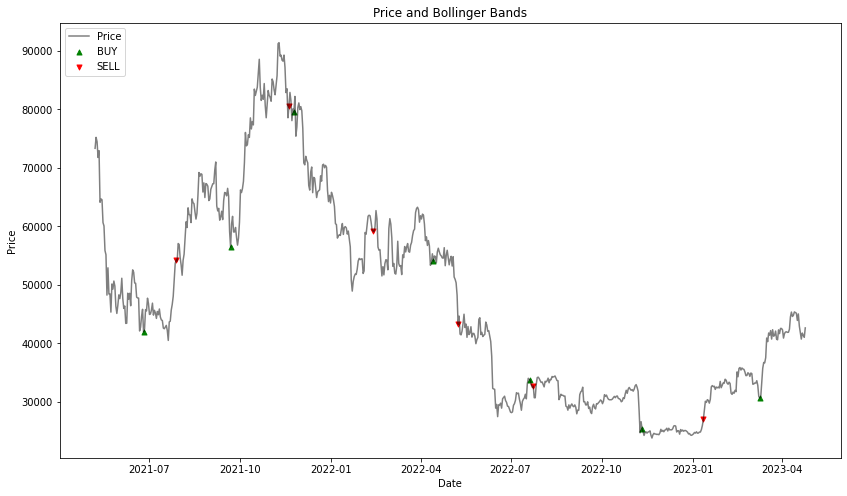

121.81498487824113

In [23]:

import matplotlib.pyplot as plt
class ExamineGenome():
    def __init__(self, genome, data):
        self.genome = genome
        self.buy_genes = BuyIndicators()
        self.sell_genes = SellIndicators()
        self.data = data
        self.data["timestamp"] = pd.to_datetime(self.data['timestamp'])
    def examine(self):
        buying = True
        fiat_money = 100
        btc_money = 0
        fee = 0.02 # Each buy or sell event costs 2% of current holdings.
        #Create a buy and sell dataframe using the genomes weights and the indicators status
        temp_df = pd.DataFrame()
        buys = [[],[]]
        sells = [[],[]]
        for i,indicator in enumerate(self.buy_genes.indicators):
            try:
                temp_df["buy"] += self.data[indicator] * self.genome.buy_genes[i]
            except KeyError:
                temp_df["buy"] = self.data[indicator] * self.genome.buy_genes[i]

        for i,indicator in enumerate(self.sell_genes.indicators):
            try:
                temp_df["sell"] += self.data[indicator] * self.genome.sell_genes[i]
            except KeyError:
                temp_df["sell"] = self.data[indicator] * self.genome.sell_genes[i]

        for index, row in self.data.iterrows():
            if buying:
                if temp_df.iloc[index]["buy"] > 0:
                    buys[0].append(row['timestamp'])
                    buys[1].append(row['close'])
                    btc_money = ( fiat_money / row['close'] ) * (1 - fee)
                    fiat_money = 0
                    buying = False

            elif temp_df.iloc[index]["sell"] > 0:
                    sells[0].append(row['timestamp'])
                    sells[1].append(row['close'])
                    fiat_money = (btc_money * row['close'] ) * (1 - fee)
                    btc_money = 0
                    buying = True
        
        plt.figure(figsize=(14, 8))
        plt.title('Price and Bollinger Bands')
        plt.scatter(buys[0], buys[1], label='BUY', color='green', s=25, marker="^")
        plt.scatter(sells[0], sells[1], label='SELL', color='red', s=25, marker="v")
        plt.plot(self.data['timestamp'], self.data['close'], label='Price', alpha=0.5, color='black')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend(loc='upper left')
        plt.show()
        return fiat_money + (btc_money * self.data.iloc[-1]['close'])

ExamineGenome(Genome(121.8149848782411,[0.27412807,  0.62986225, -0.52411716], [ 0.90028935,  0.93837371, -0.22780723]), pd.read_csv("processed_data.csv")).examine()